<a href="https://colab.research.google.com/github/renhaa/faces/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/My\ Drive/faces


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/faces


In [0]:
%run Tools.ipynb

In [0]:
"""
https://keras.io/examples/variational_autoencoder/
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


from sklearn.model_selection import train_test_split

# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon




def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    # x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()





In [0]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train.shape

11493376/11490434 [==============================] - 1s 0us/step


(60000, 28, 28)

In [10]:




# digit_size = image_size
# print(original_dim)
# print(X.shape)
# print(image_size)
# print(X_flat.shape)

# x_train.shape

16384
(5000, 128, 128)
128
(5000, 16384)


(3750, 16384)

In [0]:
class VAE:

    def __init__(self, X, summary = False):

        X = grayscale(X,expand_dim = False)
        X_flat = flatten(X,)
        self.x_train, self.x_test = train_test_split(X_flat,train_size = 0.99)

        data = self.x_test

        image_size = X.shape[1]
        # channels = X.shape[3]
        original_dim = image_size * image_size #* channels 

        input_shape = (original_dim, )
        intermediate_dim = 512
        batch_size = 128
        self.latent_dim = 100
        epochs = 10

        # VAE model = encoder + decoder
        # build encoder model
        inputs = Input(shape=input_shape, name='encoder_input')
        x = Dense(intermediate_dim, activation='relu')(inputs)
        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)

        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        # instantiate encoder model
        encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

        if summary:
            print("Encoder summary:")
            encoder.summary()
        # plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

        # build decoder model
        latent_inputs = Input(shape=(self.latent_dim,), name='z_sampling')
        x = Dense(intermediate_dim, activation='relu')(latent_inputs)
        outputs = Dense(original_dim, activation='sigmoid')(x)

        # instantiate decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        if summary:
          print("Decoder summary:")
          decoder.summary()
        
        # instantiate VAE model
        outputs = self.decoder(encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')

        models = (encoder, self.decoder)
      

        # VAE loss = mse_loss or xent_loss + kl_loss
        # if args.mse:
        #     reconstruction_loss = mse(inputs, outputs)
        # else:
        reconstruction_loss = binary_crossentropy(inputs,outputs)

        reconstruction_loss *= original_dim
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self.vae.add_loss(vae_loss)
        self.vae.compile(optimizer='adam')

        if summary:
            print("VAE summary:")
            self.vae.summary()

    def train(self, nr_epochs = 1000, batch_size = 128):

        self.vae.fit(self.x_train,
                     epochs=nr_epochs,
                      batch_size=batch_size,
                      validation_data=(self.x_test, None),
                      verbose = 0)
        # self.vae.train_on_batch(self.x_train)
        #                     #  #   epochs=nr_epochs,
        #                     #   #  batch_size=batch_size,
        #                     #     validation_data=(self.x_test, None),
        #                     #     verbose = 1)
        # vae.save_weights('vae_mlp_mnist.h5')





In [0]:
# X = np.load("data/ffhq/ffhq-100-thumbs.npy")
# X = np.load("data/ffhq/ffhq-5000-thumbs.npy")
X = np.load("data/caltech/caltech.npy")


Epoch 1
Saved to: results/vae_mlp/caltech_epoch1.png


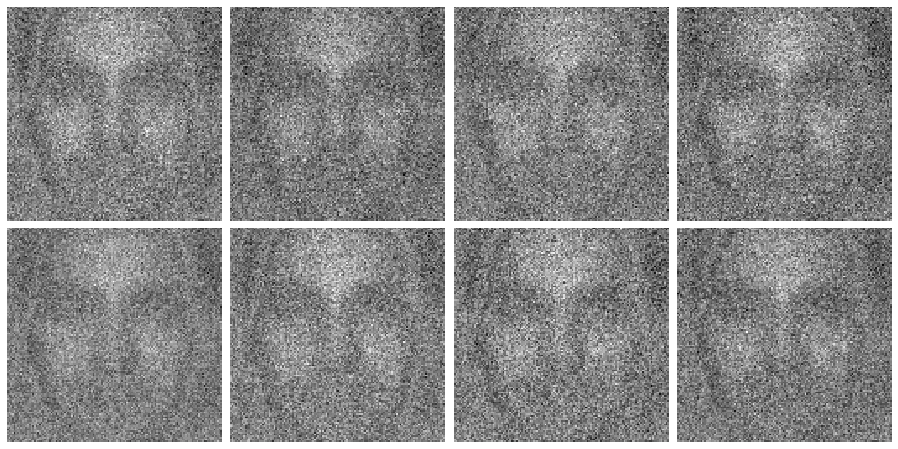

Epoch 10
Saved to: results/vae_mlp/caltech_epoch10.png


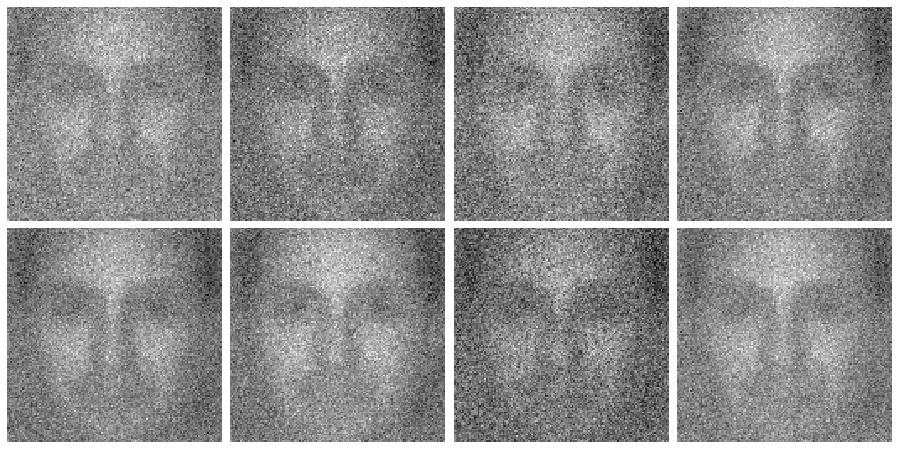

Epoch 50
Saved to: results/vae_mlp/caltech_epoch50.png


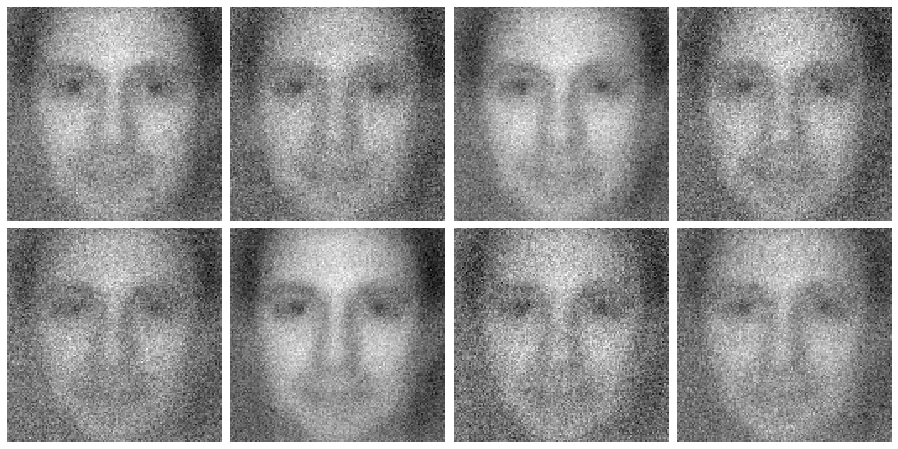

Epoch 100
Saved to: results/vae_mlp/caltech_epoch100.png


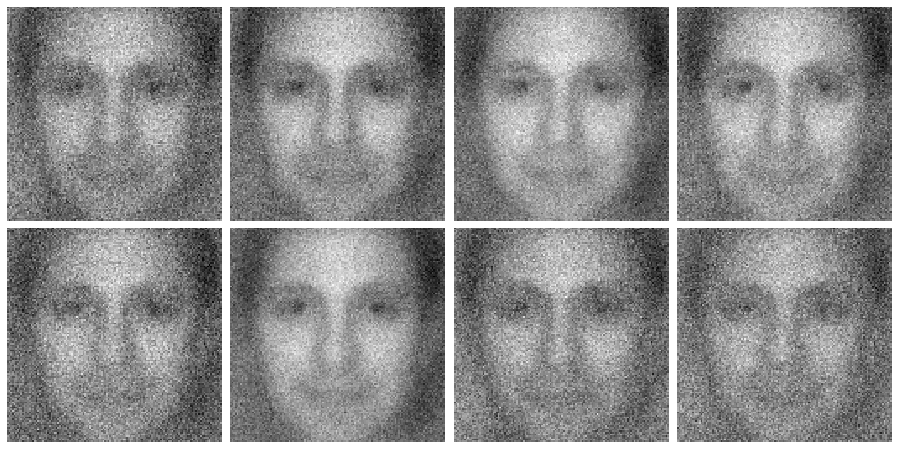

Epoch 200
Saved to: results/vae_mlp/caltech_epoch200.png


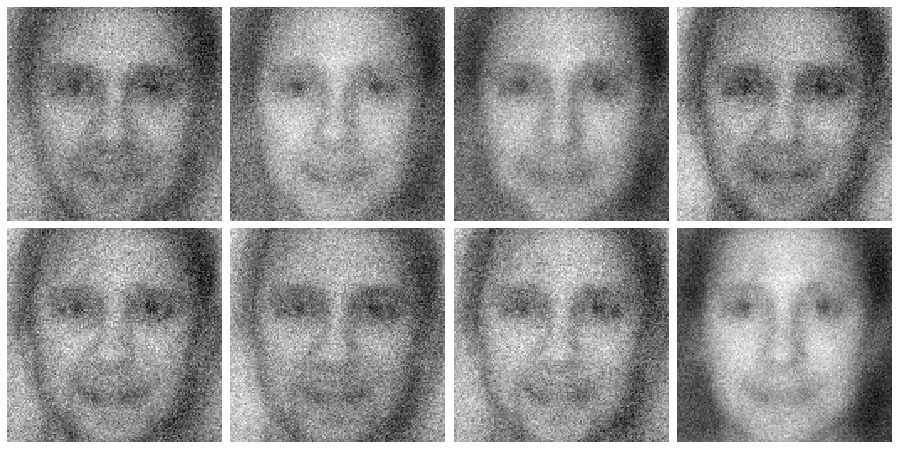

Epoch 400
Saved to: results/vae_mlp/caltech_epoch400.png


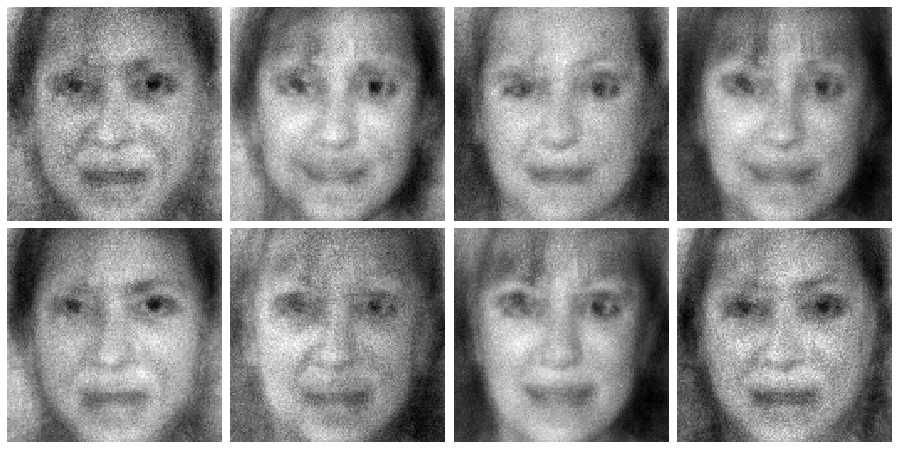

Epoch 1000
Saved to: results/vae_mlp/caltech_epoch1000.png


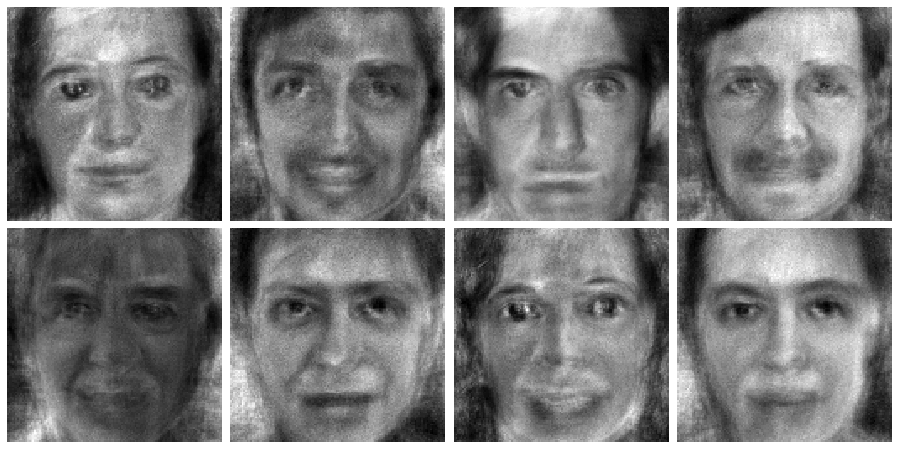

Epoch 2000
Saved to: results/vae_mlp/caltech_epoch2000.png


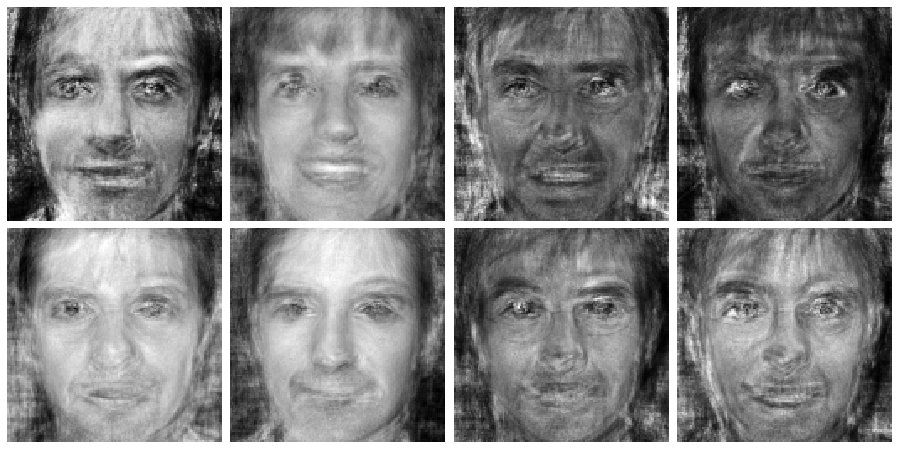

Epoch 4000


In [0]:
for e in [1, 10,50,100,200,400,1000,2000,4000,10000]:
    print("Epoch",e)
    vae = VAE(X)
    vae.train(nr_epochs = e, batch_size = 128)
    n, d, d, c = X.shape
    z_samples = np.array([np.random.normal(0, 1, size = vae.latent_dim) for i in range(10)])
    x_decoded = vae.decoder.predict(z_samples)
    x_decoded = x_decoded.reshape(10,d,d)
    plot_images(x_decoded,fname = f"results/vae_mlp/caltech_epoch{e}.png")

Saved to: results/vae_mlp/caltech_epoch1000.png


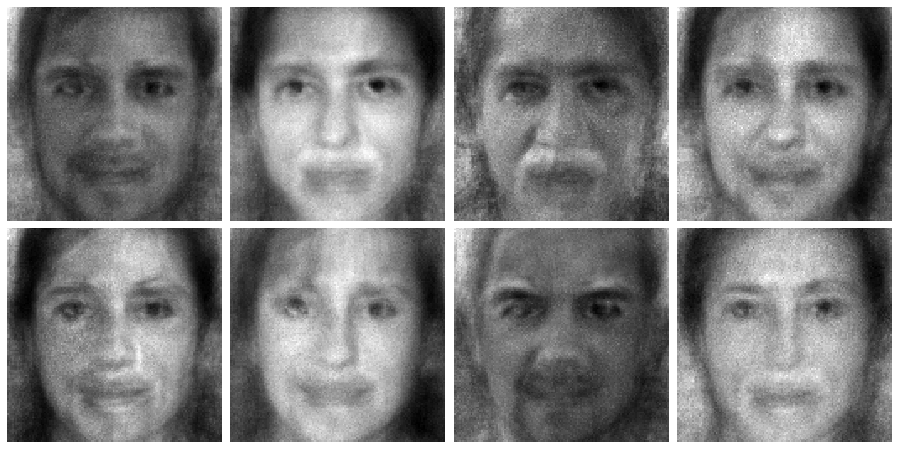

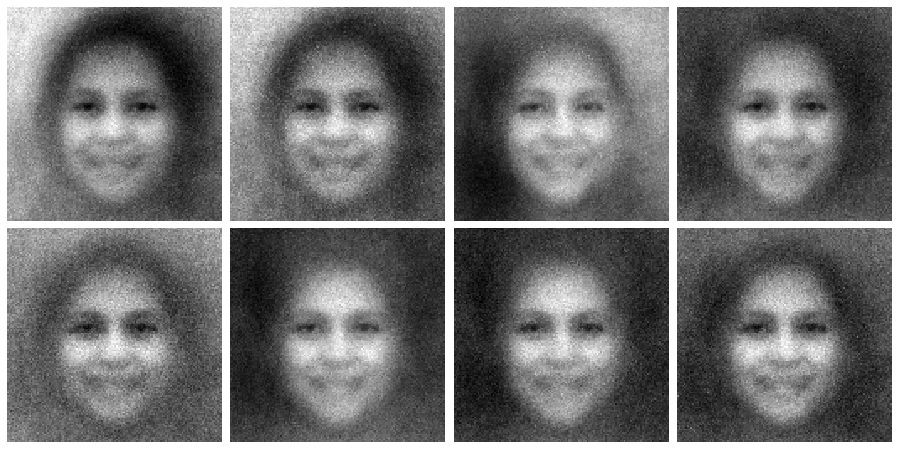

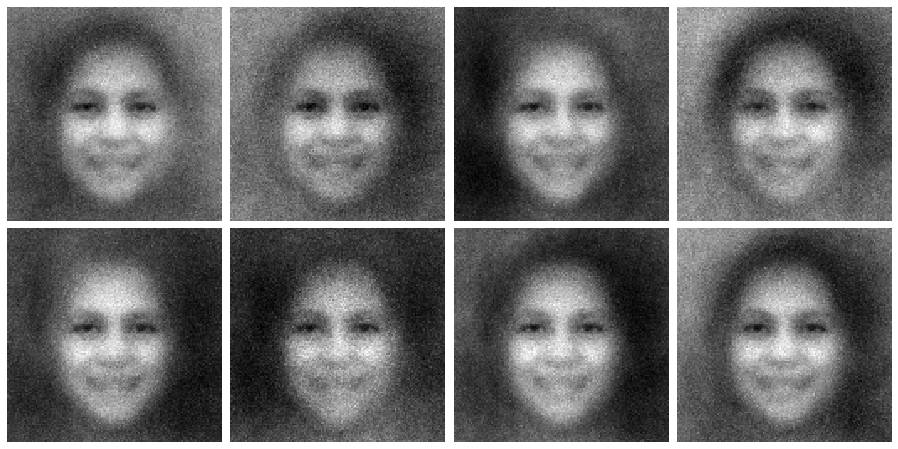

# Trash